Using TensorFlow backend.


C:\Users\herma\Apps\master-thesis\src\utils
C:\Users\herma\Apps\master-thesis
Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 13885 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows

Model lstmd 

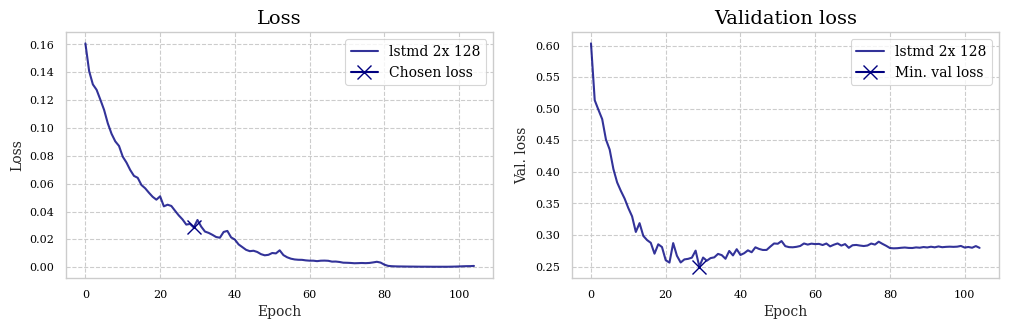

Model prediction scores
+--------------+-------------+------------+
|    Model     | Train score | Test score |
+--------------+-------------+------------+
| lstmd 2x 128 |    0.7825   |  -0.9478   |
|   linear r   |    0.4405   |  -0.9779   |
+--------------+-------------+------------+


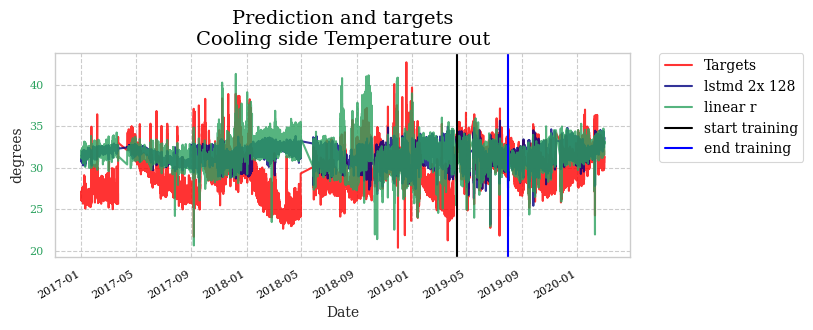

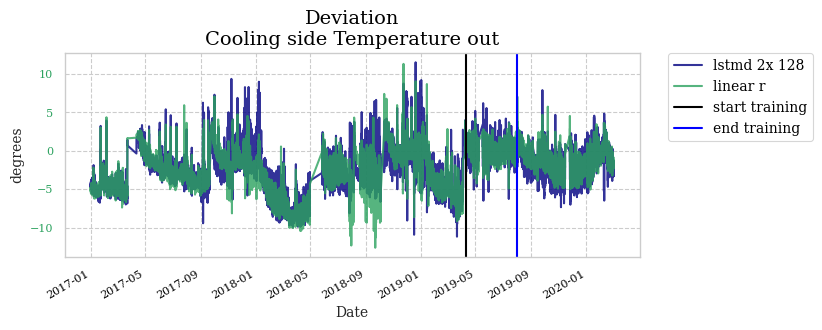

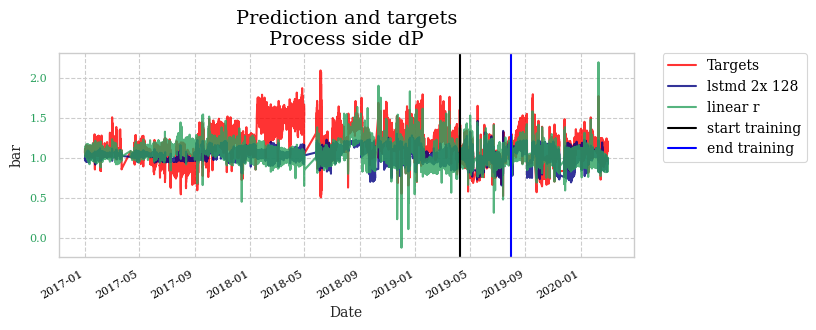

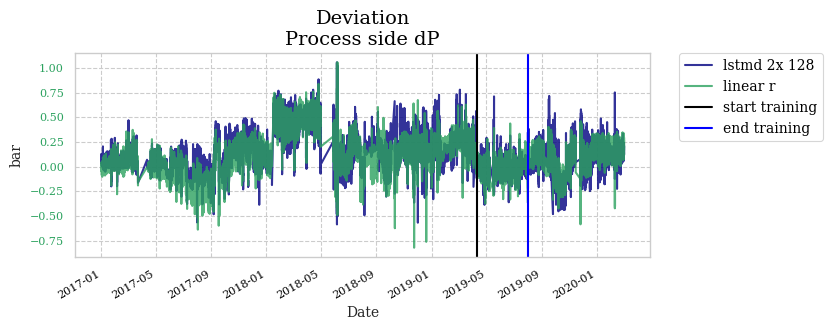

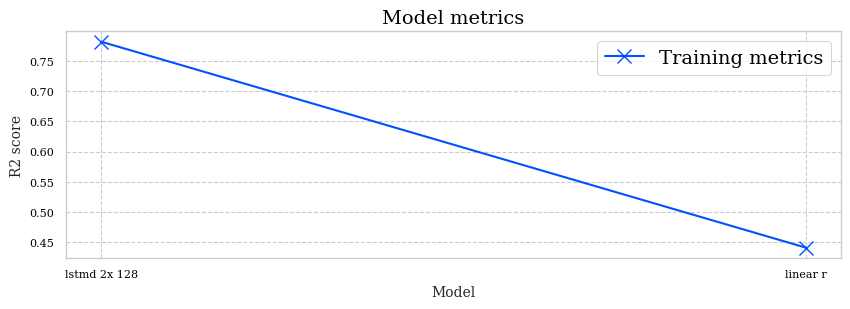

In [1]:
# %load example_G_lstm_comparison.py
import src.core as mlApi

# 1. Define dataset specifics

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_10min.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
	['PDI0064', 'Process side dP', 'bar'],
	['TI0066', 'Process side Temperature out','degrees'],
	['TZI0012', 'Process side Temperature in', 'degrees'],
	['FI0010', 'Process side flow rate', 'MSm^3/d(?)'],
	['TT0025', 'Cooling side Temperature in', 'degrees'],
	['TT0026', 'Cooling side Temperature out', 'degrees'],
	['PI0001', 'Cooling side Pressure in', 'barG'],
	['FI0027', 'Cooling side flow rate', 'MSm^3/d(?)'],
	['TIC0022U', 'Cooling side valve opening', '%'],
	['PDT0024', 'Cooling side dP', 'bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
    'PDI0064',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

# 2. Initiate and divide data

df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models

lstm_1x_128 = mlApi.LSTM('lstm 1x 128', layers=[128])

lstmd_1x_16 = mlApi.LSTM('lstmd 1x 16', layers=[16], dropout=0.3)
lstmd_1x_32 = mlApi.LSTM('lstmd 1x 32', layers=[32], dropout=0.3)
lstmd_1x_64 = mlApi.LSTM('lstmd 1x 64', layers=[64], dropout=0.3)
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128', layers=[128], dropout=0.3)

lstmd_2x_16 = mlApi.LSTM('lstmd 2x 16', layers=[16, 16], dropout=0.3)
lstmd_2x_32 = mlApi.LSTM('lstmd 2x 32', layers=[32, 32], dropout=0.3)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64', layers=[64, 64], dropout=0.3)
lstmd_2x_128 = mlApi.LSTM('lstmd 2x 128', layers=[128, 128], dropout=0.3)

linear_cv = mlApi.Linear_Regularized('linear r')

mlp_d = mlApi.MLP('mlp for ensemble 2x 64', layers=[64, 64], dropout=0.2)

ensemble = mlApi.Ensemble('lstmd + linear', [lstmd_2x_64, linear_cv])
ensemble2 = mlApi.Ensemble('lstmd2 + linear', [lstmd_1x_128, linear_cv])
ensemble3 = mlApi.Ensemble('lstm + mlp', [lstmd_2x_64, mlp_d])

modelList = [
    #lstmd_1x_16,
    #lstmd_1x_32,
    #lstmd_1x_64,
    #lstmd_1x_128,
    #lstmd_2x_16,
    #lstmd_2x_32,
    #lstmd_2x_64,
    lstmd_2x_128,
    #ensemble,
    #ensemble2,
	#ensemble3,
    linear_cv,
]

# 4. Initiate and train models

# Define whether to retrain models or not
retrain=False

mlApi.initModels(modelList)
mlApi.trainModels(retrain)
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
)